In [5]:
import time
import asyncio
from io import StringIO

from onnxruntime.transformers.models.gpt2.gpt2_parity import score
from pinecone.grpc import PineconeGRPC as Pinecone
from IPython.display import Markdown, display
from openai import OpenAI
from src.data_processing import *
import pandas as pd
import warnings
from dotenv import load_dotenv
warnings.filterwarnings("ignore")
# Load environment variables from the .env file
load_dotenv()

# Set API keys from environment variables
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")
pinecone_api_key = os.getenv("PINECONE_API_KEY")

async def retriever(query: str, PINECONE_API_KEY: str, OPENAI_API_KEY:str, top_k: int = 20):
    """
    Asynchronous retriever function that retrieves context relevant to a query by
    utilizing embeddings generated by OpenAI and querying a Pinecone index. This
    function combines metadata from matching results to form a consolidated
    context output.

    :param query: The input query for which relevant context must be retrieved
    :param PINECONE_API_KEY: The API key for accessing the Pinecone service
    :param OPENAI_API_KEY: The API key for accessing the OpenAI service
    :param top_k: The maximum number of top results to retrieve from the index.
                  Defaults to 10.
    :return: A string containing the consolidated context generated by combining
             unique metadata retrieved from the Pinecone index
    :rtype: str
    """

    # Load Pinecone Index
    pc = Pinecone(PINECONE_API_KEY)
    index = pc.Index("legal-assistant-rag")

    # Load OpenAI Client
    client = OpenAI(api_key=OPENAI_API_KEY)

    loop = asyncio.get_event_loop()

    # Asynchronously create embedding
    embedding_result = await loop.run_in_executor(
        None,
        lambda: client.embeddings.create(input=query, model="text-embedding-3-large")
    )
    xq = embedding_result.data[0].embedding

    # Asynchronously query the Pinecone index
    res = await loop.run_in_executor(
        None,
        lambda: index.query(vector=xq, top_k=top_k, include_metadata=True)
    )
    res.matches = sorted(res.matches, key=lambda chunk: int(chunk['id']))

    # Combine Chunks
    chunk_list = []
    for r in res.matches:
        chunk_list.append(r["metadata"]["prechunk"])
        chunk_list.append(r["metadata"]["content"])
        chunk_list.append(r["metadata"]["postchunk"])
    unique_chunks = list(set(chunk_list))
    question_context = " ".join(unique_chunks)
    return question_context

In [8]:
query = "What are main requirements for Regulation K?"
top_k = 20

# Load Pinecone Index
pc = Pinecone(os.getenv("PINECONE_API_KEY"))
index = pc.Index("legal-assistant-rag")

# Load OpenAI Client
client = OpenAI(api_key=openai_api_key)

loop = asyncio.get_event_loop()

# Asynchronously create embedding
embedding_result = await loop.run_in_executor(
    None,
    lambda: client.embeddings.create(input=query, model="text-embedding-3-large")
)
xq = embedding_result.data[0].embedding

# Asynchronously query the Pinecone index
res = await loop.run_in_executor(
    None,
    lambda: index.query(vector=xq, top_k=top_k, include_metadata=True)
)
res.matches = sorted(res.matches, key=lambda chunk: int(chunk['id']))

<Axes: ylabel='Count'>

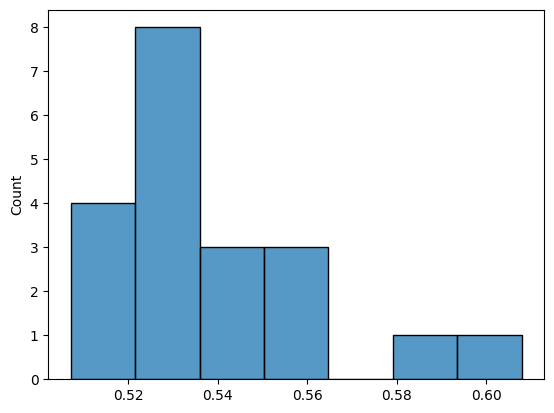

In [21]:
import seaborn as sns

scores = []
for r in res.matches:
    scores.append(r["score"])

sns.histplot(scores)

In [27]:
res.matches[i]["score"]

0.50982845